In [13]:
# ============================================================================
# FinanceBench Evaluation: MRR Analysis
# Comparing Embedding Models and Chunk Sizes
# ============================================================================

# %% [markdown]
# # FinanceBench RAG Evaluation
# 
# This notebook evaluates different embedding models and chunk sizes using
# Mean Reciprocal Rank (MRR) on the FinanceBench dataset.

# %% [markdown]
# ## 1.1 Imports

# %%
import os
import json
from pathlib import Path
from typing import List, Dict, Tuple, Optional
from collections import defaultdict

# Environment
from dotenv import load_dotenv

# Progress
from tqdm.auto import tqdm

# Data
from datasets import load_dataset

# Vector stores
from langchain.vectorstores import Chroma
from langchain_ollama import OllamaEmbeddings
from langchain_openai import OpenAIEmbeddings

print("✓ Imports successful")

# Load .env file
load_dotenv()

# %% [markdown]
# ## 1.2 Configuration
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
OLLAMA_BASE_URL = os.getenv("OLLAMA_BASE_URL", "http://localhost:11434")

if OPENAI_API_KEY:
    print("✓ OpenAI API key loaded")
else:
    print("⚠ OpenAI API key not found (only needed if using OpenAI embeddings)")

print(f"✓ Ollama URL: {OLLAMA_BASE_URL}")

# %%
# Paths
VECTOR_DB_BASE_DIR = "../../vector_databases"
OUTPUT_DIR = "../../evaluation_results/mrr_embeddings"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Dataset
DATASET_NAME = "PatronusAI/financebench"
DATASET_SPLIT = "train"

# Collection settings
COLLECTION_PREFIX = "financebench_docs_chunk_"

print("✓ Configuration set")
print(f"  Vector DB Directory: {VECTOR_DB_BASE_DIR}")
print(f"  Output Directory: {OUTPUT_DIR}")

# %% [markdown]
# ## 1.3 Load Dataset

# %%
print("Loading FinanceBench dataset...")
dataset = load_dataset(DATASET_NAME, split=DATASET_SPLIT)
print(f"✓ Loaded {len(dataset)} queries")

# Show sample
print("\nSample query:")
sample = dataset[0]
print(f"  ID: {sample['financebench_id']}")
print(f"  Company: {sample['company']}")
print(f"  Question: {sample['question'][:100]}...")
print(f"  Doc: {sample['doc_name']}")
print(f"  Evidence items: {len(sample['evidence'])}")

✓ Imports successful
✓ OpenAI API key loaded
✓ Ollama URL: http://localhost:11434
✓ Configuration set
  Vector DB Directory: ../../vector_databases
  Output Directory: ../../evaluation_results/mrr_embeddings
Loading FinanceBench dataset...
✓ Loaded 150 queries

Sample query:
  ID: financebench_id_03029
  Company: 3M
  Question: What is the FY2018 capital expenditure amount (in USD millions) for 3M? Give a response to the quest...
  Doc: 3M_2018_10K
  Evidence items: 1


In [14]:
# ============================================================================
# Step 2: Helper Functions
# ============================================================================

# %% [markdown]
# ## 2.1 Metadata Extraction

# %%
def extract_doc_name_from_path(file_path: str) -> str:
    """
    Extract document name from file path.
    
    Example: "../../financebench/documents/GENERALMILLS_2019_10K.pdf" 
             -> "GENERALMILLS_2019_10K"
    """
    filename = os.path.basename(file_path)
    doc_name = filename.replace('.pdf', '')
    return doc_name


def extract_metadata_from_retrieved_doc(doc) -> Dict:
    """Extract relevant metadata from retrieved document."""
    file_path = doc.metadata.get('file_path', '')
    doc_name = extract_doc_name_from_path(file_path)
    page_num = doc.metadata.get('source', -1)
    
    # Ensure page_num is an integer
    if isinstance(page_num, str):
        page_num = int(page_num)
    
    return {
        'doc_name': doc_name,
        'page_number': page_num
    }

# %% [markdown]
# ## 2.2 Vector Store Loading

# %%
def get_embedding_function(provider: str, model: str):
    """Get embedding function."""
    if provider == "ollama":
        return OllamaEmbeddings(model=model)
    elif provider == "openai":
        return OpenAIEmbeddings(model=model, openai_api_key=OPENAI_API_KEY)
    else:
        raise ValueError(f"Unknown provider: {provider}")


def load_vectorstore(
    provider: str,
    model: str,
    chunk_size: int,
    base_dir: str = VECTOR_DB_BASE_DIR,
    collection_prefix: str = COLLECTION_PREFIX
) -> Chroma:
    """Load a vector store."""
    model_id = f"{provider}_{model.replace('/', '_')}"
    db_path = os.path.join(base_dir, model_id)
    collection_name = f"{collection_prefix}{chunk_size}"
    
    emb_fn = get_embedding_function(provider, model)
    
    vectorstore = Chroma(
        collection_name=collection_name,
        embedding_function=emb_fn,
        persist_directory=db_path
    )
    
    return vectorstore

# %% [markdown]
# ## 2.3 Evidence Matching

# %%
def check_match(retrieved_doc: Dict, evidence_list: List[Dict]) -> bool:
    """
    Check if retrieved document matches any evidence.
    
    Note: FinanceBench evidence page numbers are 0-indexed (page 0 = first page)
          ChromaDB source metadata is 1-indexed (source 1 = first page)
          So we add 1 to evidence page number for comparison.
    
    Args:
        retrieved_doc: {doc_name, page_number} where page_number is from ChromaDB source (1-indexed)
        evidence_list: List of evidence dicts from FinanceBench (0-indexed page numbers)
        
    Returns:
        True if match found
    """
    retrieved_doc_name = retrieved_doc['doc_name']
    retrieved_page = retrieved_doc['page_number']
    
    for evidence in evidence_list:
        evidence_doc_name = evidence['doc_name']
        evidence_page = evidence['evidence_page_num'] + 1  # Convert 0-indexed to 1-indexed
        
        if retrieved_doc_name == evidence_doc_name and retrieved_page == evidence_page:
            return True
    
    return False

# %% [markdown]
# ## 2.4 MRR Calculation (Modular)

# %%
def calculate_mrr_for_query(retrieved_docs: List[Dict], evidence_list: List[Dict]) -> Tuple[float, int]:
    """
    Calculate MRR for a single query.
    
    Args:
        retrieved_docs: List of {doc_name, page_number}
        evidence_list: Ground truth evidence
        
    Returns:
        Tuple of (mrr_score, rank)
        - mrr_score: 1/rank if found, 0 if not found
        - rank: Position of first match (1-indexed), -1 if not found
    """
    for rank, retrieved_doc in enumerate(retrieved_docs, start=1):
        if check_match(retrieved_doc, evidence_list):
            mrr_score = 1.0 / rank
            return mrr_score, rank
    
    # No match found
    return 0.0, -1

# %% [markdown]
# ## 2.5 Retrieval Functions

# %%
def retrieve_global(
    vectorstore: Chroma,
    query: str,
    k: int
) -> List[Dict]:
    """
    Retrieve documents globally (search all documents).
    
    Returns:
        List of {doc_name, page_number, rank}
    """
    results = vectorstore.similarity_search(query, k=k)
    retrieved = []
    for rank, doc in enumerate(results, start=1):
        metadata = extract_metadata_from_retrieved_doc(doc)
        metadata['rank'] = rank
        retrieved.append(metadata)
    return retrieved


def retrieve_single_doc(
    vectorstore: Chroma,
    query: str,
    target_doc_name: str,
    k: int
) -> List[Dict]:
    """
    Retrieve documents filtered to single document.
    
    Since ChromaDB doesn't support $contains, we retrieve more documents
    and filter them post-retrieval.
    
    Returns:
        List of {doc_name, page_number, rank}
    """
    # Retrieve more documents than needed (k * 10) to ensure we get enough from target doc
    # Then filter to only the target document
    
    fetch_k = min(k * 10, 100)  # Fetch up to 10x k, max 100
    
    results = vectorstore.similarity_search(query, k=fetch_k)
    
    # Filter to only documents from target doc
    filtered = []
    for doc in results:
        metadata = extract_metadata_from_retrieved_doc(doc)
        if metadata['doc_name'] == target_doc_name:
            filtered.append(metadata)
            if len(filtered) >= k:
                break
    
    # Add rank after filtering
    for rank, doc_meta in enumerate(filtered[:k], start=1):
        doc_meta['rank'] = rank
    
    # Return top k from target document
    return filtered[:k]

# %% [markdown]
# ## 2.6 File Management

# %%
def get_output_filename(provider: str, model: str, chunk_size: int, k: int, mode: str) -> str:
    """Generate output filename."""
    model_clean = model.replace('/', '_')
    filename = f"{provider}_{model_clean}_chunk{chunk_size}_k{k}_{mode}.json"
    return filename


def check_if_results_exist(provider: str, model: str, chunk_size: int, k: int, mode: str, output_dir: str) -> bool:
    """Check if results JSON already exists."""
    filename = get_output_filename(provider, model, chunk_size, k, mode)
    filepath = os.path.join(output_dir, filename)
    return os.path.exists(filepath)


def save_results(results: List[Dict], provider: str, model: str, chunk_size: int, k: int, mode: str, output_dir: str):
    """Save results to JSON file."""
    filename = get_output_filename(provider, model, chunk_size, k, mode)
    filepath = os.path.join(output_dir, filename)
    
    with open(filepath, 'w') as f:
        json.dump(results, f, indent=2)
    
    print(f"✓ Saved: {filename}")

# %%
print("✓ Helper functions defined")

✓ Helper functions defined


In [15]:
# ============================================================================
# Step 3: Evaluation Loop
# ============================================================================

# %% [markdown]
# ## 3.1 Single Evaluation Run

# %%
def evaluate_single_configuration(
    dataset,
    provider: str,
    model: str,
    chunk_size: int,
    k: int,
    mode: str,
    output_dir: str = OUTPUT_DIR
) -> Dict:
    """
    Evaluate a single configuration (provider, model, chunk_size, k, mode).
    
    Args:
        dataset: FinanceBench dataset
        provider: "ollama" or "openai"
        model: Model name
        chunk_size: Chunk size
        k: Number of documents to retrieve
        mode: "global" or "singledoc"
        output_dir: Output directory
        
    Returns:
        Dictionary with results
    """
    print(f"\n{'='*60}")
    print(f"EVALUATING: {provider}/{model}, chunk={chunk_size}, k={k}, mode={mode}")
    print(f"{'='*60}")
    
    # Check if already exists
    if check_if_results_exist(provider, model, chunk_size, k, mode, output_dir):
        print("✓ Results already exist - SKIPPING")
        return {'status': 'skipped'}
    
    # Load vectorstore
    print("Loading vectorstore...")
    try:
        vectorstore = load_vectorstore(provider, model, chunk_size)
        doc_count = vectorstore._collection.count()
        print(f"✓ Loaded ({doc_count:,} documents)")
    except Exception as e:
        print(f"✗ Failed to load vectorstore: {e}")
        return {'status': 'failed', 'error': str(e)}
    
    # Process all queries
    results = []
    mrr_scores = []
    
    print(f"\nProcessing {len(dataset)} queries...")
    
    for record in tqdm(dataset, desc="Queries"):
        query_id = record['financebench_id']
        query = record['question']
        evidence = record['evidence']
        doc_name = record['doc_name']
        
        # Retrieve documents
        try:
            if mode == "global":
                retrieved_docs = retrieve_global(vectorstore, query, k)
            elif mode == "singledoc":
                retrieved_docs = retrieve_single_doc(vectorstore, query, doc_name, k)
            else:
                raise ValueError(f"Unknown mode: {mode}")
            
            # Calculate MRR
            mrr_score, rank = calculate_mrr_for_query(retrieved_docs, evidence)
            mrr_scores.append(mrr_score)
            
            # Store result
            result = {
                'query_id': query_id,
                'query': query,
                'expected_doc': doc_name,
                'expected_evidence': [
                    {
                        'doc_name': ev['doc_name'],
                        'page_number': ev['evidence_page_num']
                    }
                    for ev in evidence
                ],
                'retrieved_docs': retrieved_docs,
                'mrr_score': mrr_score,
                'rank': rank
            }
            results.append(result)
            
        except Exception as e:
            print(f"\n✗ Error processing query {query_id}: {e}")
            results.append({
                'query_id': query_id,
                'query': query,
                'error': str(e),
                'mrr_score': 0.0,
                'rank': -1
            })
            mrr_scores.append(0.0)
    
    # Calculate average MRR
    avg_mrr = sum(mrr_scores) / len(mrr_scores) if mrr_scores else 0.0
    
    # Add summary
    results.append({
        'summary': {
            'provider': provider,
            'model': model,
            'chunk_size': chunk_size,
            'k': k,
            'mode': mode,
            'total_queries': len(dataset),
            'average_mrr': avg_mrr
        }
    })
    
    # Save results
    save_results(results, provider, model, chunk_size, k, mode, output_dir)
    
    print(f"\n✓ Average MRR: {avg_mrr:.4f}")
    
    return {
        'status': 'completed',
        'average_mrr': avg_mrr,
        'total_queries': len(dataset)
    }

# %% [markdown]
# ## 3.2 Batch Evaluation

# %%
def evaluate_multiple_configurations(
    dataset,
    configurations: List[Dict],
    k_values: List[int],
    modes: List[str],
    output_dir: str = OUTPUT_DIR
) -> Dict:
    """
    Evaluate multiple configurations.
    
    Args:
        dataset: FinanceBench dataset
        configurations: List of {provider, model, chunk_sizes}
        k_values: List of k values to test
        modes: List of modes ["global", "singledoc"]
        output_dir: Output directory
        
    Returns:
        Summary of all evaluations
    """
    print(f"\n{'='*60}")
    print("BATCH EVALUATION")
    print(f"{'='*60}")
    print(f"Configurations: {len(configurations)}")
    print(f"K values: {k_values}")
    print(f"Modes: {modes}")
    
    # Calculate total runs
    total_runs = 0
    for config in configurations:
        total_runs += len(config['chunk_sizes']) * len(k_values) * len(modes)
    
    print(f"Total evaluation runs: {total_runs}")
    print(f"{'='*60}")
    
    # Track results
    all_results = []
    completed = 0
    skipped = 0
    failed = 0
    
    # Iterate through all combinations
    for config in configurations:
        provider = config['provider']
        model = config['model']
        chunk_sizes = config['chunk_sizes']
        
        for chunk_size in chunk_sizes:
            for k in k_values:
                for mode in modes:
                    result = evaluate_single_configuration(
                        dataset=dataset,
                        provider=provider,
                        model=model,
                        chunk_size=chunk_size,
                        k=k,
                        mode=mode,
                        output_dir=output_dir
                    )
                    
                    all_results.append({
                        'provider': provider,
                        'model': model,
                        'chunk_size': chunk_size,
                        'k': k,
                        'mode': mode,
                        'result': result
                    })
                    
                    if result['status'] == 'completed':
                        completed += 1
                    elif result['status'] == 'skipped':
                        skipped += 1
                    else:
                        failed += 1
    
    # Summary
    print(f"\n{'='*60}")
    print("BATCH EVALUATION SUMMARY")
    print(f"{'='*60}")
    print(f"Total runs: {total_runs}")
    print(f"Completed: {completed}")
    print(f"Skipped: {skipped}")
    print(f"Failed: {failed}")
    print(f"{'='*60}")
    
    return {
        'total_runs': total_runs,
        'completed': completed,
        'skipped': skipped,
        'failed': failed,
        'results': all_results
    }

# %%
print("✓ Evaluation functions defined")

✓ Evaluation functions defined


In [16]:
# ============================================================================
# Test Retrieval Function
# ============================================================================

# %% [markdown]
# ## Test Retrieval with Sample Text
# 
# Use this to verify embeddings are working correctly by testing with 
# known text from your documents.

# %%
def test_retrieval(
    query_text: str,
    provider: str,
    model: str,
    chunk_size: int,
    k: int = 10,
    mode: str = "global",
    target_doc_name: str = None
):
    """
    Test retrieval with a sample query.
    
    Args:
        query_text: Text to search for (copy from actual document)
        provider: "ollama" or "openai"
        model: Model name
        chunk_size: Chunk size to test
        k: Number of results
        mode: "global" or "singledoc"
        target_doc_name: Required if mode is "singledoc"
    """
    print("="*60)
    print("TEST RETRIEVAL")
    print("="*60)
    print(f"Provider: {provider}")
    print(f"Model: {model}")
    print(f"Chunk size: {chunk_size}")
    print(f"Mode: {mode}")
    print(f"K: {k}")
    print(f"\nQuery (first 200 chars):")
    print(f"{query_text[:200]}...")
    print("="*60)
    
    # Load vectorstore
    try:
        vectorstore = load_vectorstore(provider, model, chunk_size)
        print(f"✓ Vectorstore loaded")
    except Exception as e:
        print(f"✗ Failed to load: {e}")
        return
    
    # Retrieve
    try:
        if mode == "global":
            results = retrieve_global(vectorstore, query_text, k)
        elif mode == "singledoc":
            if not target_doc_name:
                print("✗ target_doc_name required for singledoc mode")
                return
            results = retrieve_single_doc(vectorstore, query_text, target_doc_name, k)
        else:
            print(f"✗ Unknown mode: {mode}")
            return
        
        print(f"\n✓ Retrieved {len(results)} documents")
        
        # Display results
        print("\n" + "="*60)
        print("RESULTS")
        print("="*60)
        
        for doc_meta in results:
            print(f"\nRank {doc_meta['rank']}: {doc_meta['doc_name']}, Page {doc_meta['page_number']}")
        
        # Check if top result seems correct
        if results:
            print("\n" + "="*60)
            print("TOP RESULT ANALYSIS")
            print("="*60)
            top = results[0]
            print(f"Document: {top['doc_name']}")
            print(f"Page: {top['page_number']}")
            print(f"Rank: {top['rank']}")
            
            # Try to get the actual content
            try:
                full_results = vectorstore.similarity_search(query_text, k=1)
                if full_results:
                    content = full_results[0].page_content
                    print(f"\nTop result content (first 300 chars):")
                    print(f"{content[:300]}...")
            except Exception as e:
                print(f"Could not fetch content: {e}")
        
        return results
        
    except Exception as e:
        print(f"\n✗ Retrieval failed: {e}")
        return None

In [17]:
# %% [markdown]
# ## Example Usage

# %%
# Example #1: GENERALMILLS 2019 10K - Page 50/140
sample_query1 = """
The management of General Mills, Inc. is responsible for the fairness and accuracy of the consolidated financial statements. The statements have been
prepared in accordance with accounting principles that are generally accepted in the United States, using management’s best estimates and judgments where
appropriate. The financial information throughout this Annual Report on Form 10-K is consistent with our consolidated financial statements.
Management has established a system of internal controls that provides reasonable assurance that assets are adequately safeguarded and transactions are
recorded accurately in all material respects, in accordance with management’s authorization. We maintain a strong audit program that independently
evaluates the adequacy and effectiveness of internal controls. Our internal controls provide for appropriate separation of duties and responsibilities, and
there are documented policies regarding use of our assets and proper financial reporting. These formally stated and regularly communicated policies
demand highly ethical conduct from all employees.
The Audit Committee of the Board of Directors meets regularly with management, internal auditors, and our independent registered public accounting firm
to review internal control, auditing, and financial reporting matters. The independent registered public accounting firm, internal auditors, and employees
have full and free access to the Audit Committee at any time.
The Audit Committee reviewed and approved the Company’s annual financial statements. The Audit Committee recommended, and the Board of Directors
approved, that the consolidated financial statements be included in the Annual Report. The Audit Committee also appointed KPMG LLP to serve as the
Company’s independent registered public accounting firm for fiscal 2020
"""

test_retrieval(
    query_text=sample_query1,
    provider="ollama",
    model="nomic-embed-text",
    chunk_size=512,
    k=10,
    mode= "singledoc", # "global", "singledoc"
    target_doc_name= "GENERALMILLS_2019_10K" # no need if mode is "global"
)

sample_query2 = """
SG&A, measured as a percent of sales, increased in 2022 when compared to the same period last year. SG&A was impacted by increased special item costs for significant\nlitigation primarily related to steps toward resolving Combat Arms Earplugs litigation (discussed in Note 16) resulting in a 2022 second quarter pre-tax charge of approximately\n$1.2 billion, certain impairment costs related to exiting PFAS manufacturing (see Note 15), costs related to exiting Russia (see Note 15), divestiture-related
"""

test_retrieval(
    query_text=sample_query2,
    provider="ollama",
    model="nomic-embed-text",
    chunk_size=256,
    k=10,
    mode= "singledoc", # "global", "singledoc"
    target_doc_name= "3M_2022_10K" # no need if mode is "global"
)

# %%
# Example: Test single-doc mode
# test_retrieval(
#     query_text="Your sample text here",
#     provider="ollama",
#     model="nomic-embed-text",
#     chunk_size=512,
#     k=10,
#     mode="singledoc",
#     target_doc_name="3M_2018_10K"
# )

TEST RETRIEVAL
Provider: ollama
Model: nomic-embed-text
Chunk size: 512
Mode: singledoc
K: 10

Query (first 200 chars):

The management of General Mills, Inc. is responsible for the fairness and accuracy of the consolidated financial statements. The statements have been
prepared in accordance with accounting principles...


/var/folders/lj/175ptt0d6knb0gg0lg2h4n2h0000gp/T/ipykernel_61087/4097869806.py:64: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vectorstore = Chroma(


✓ Vectorstore loaded

✓ Retrieved 10 documents

RESULTS

Rank 1: GENERALMILLS_2019_10K, Page 50

Rank 2: GENERALMILLS_2019_10K, Page 110

Rank 3: GENERALMILLS_2019_10K, Page 51

Rank 4: GENERALMILLS_2019_10K, Page 136

Rank 5: GENERALMILLS_2019_10K, Page 52

Rank 6: GENERALMILLS_2019_10K, Page 51

Rank 7: GENERALMILLS_2019_10K, Page 58

Rank 8: GENERALMILLS_2019_10K, Page 110

Rank 9: GENERALMILLS_2019_10K, Page 139

Rank 10: GENERALMILLS_2019_10K, Page 140

TOP RESULT ANALYSIS
Document: GENERALMILLS_2019_10K
Page: 50
Rank: 1

Top result content (first 300 chars):
45 
 
ITEM 8 - Financial Statements and Supplementary Data  
 
REPORT OF MANAGEMENT RESPONSIBILITIES 
 
The management of General Mills, Inc. is responsible for the fairness and accuracy of the consolidated financial statements. The 
statements have been prepared in accordance with accounting princi...
TEST RETRIEVAL
Provider: ollama
Model: nomic-embed-text
Chunk size: 256
Mode: singledoc
K: 10

Query (first 200 chars):

SG&A

[{'doc_name': '3M_2022_10K', 'page_number': 27, 'rank': 1},
 {'doc_name': '3M_2022_10K', 'page_number': 27, 'rank': 2},
 {'doc_name': '3M_2022_10K', 'page_number': 30, 'rank': 3},
 {'doc_name': '3M_2022_10K', 'page_number': 39, 'rank': 4},
 {'doc_name': '3M_2022_10K', 'page_number': 29, 'rank': 5},
 {'doc_name': '3M_2022_10K', 'page_number': 24, 'rank': 6},
 {'doc_name': '3M_2022_10K', 'page_number': 31, 'rank': 7},
 {'doc_name': '3M_2022_10K', 'page_number': 22, 'rank': 8},
 {'doc_name': '3M_2022_10K', 'page_number': 65, 'rank': 9},
 {'doc_name': '3M_2022_10K', 'page_number': 20, 'rank': 10}]

In [ ]:
# ============================================================================
# Step 4: Configuration and Execution
# ============================================================================

# %% [markdown]
# ## 4.1 Define Configurations to Test

# %%
# Define which embedding models and chunk sizes to evaluate
configurations = [
    {
        'provider': 'ollama',
        'model': 'bge-m3',
        'chunk_sizes': [256, 512, 1024]
    },
    {
        'provider': 'ollama',
        'model': 'nomic-embed-text',
        'chunk_sizes': [256, 512, 1024]
    },
    # Add more configurations as needed:
    {
        'provider': 'openai',
        'model': 'text-embedding-3-small',
        'chunk_sizes': [512]
    },

]

# %% [markdown]
# ## 4.2 Define Evaluation Parameters

# %%
# K values to test (number of documents to retrieve)
k_values = [40]

# Modes to test
modes = ['global', 'singledoc']

# %% [markdown]
# ## 4.3 Display Evaluation Plan

# %%
print("="*60)
print("EVALUATION PLAN")
print("="*60)

total_runs = 0
for config in configurations:
    provider = config['provider']
    model = config['model']
    chunk_sizes = config['chunk_sizes']
    
    print(f"\n{provider}/{model}")
    print(f"  Chunk sizes: {chunk_sizes}")
    
    runs_for_config = len(chunk_sizes) * len(k_values) * len(modes)
    total_runs += runs_for_config
    
    print(f"  Evaluation runs: {runs_for_config}")
    
    # Show output filenames that will be generated
    print(f"  Output files:")
    for chunk_size in chunk_sizes:
        for k in k_values:
            for mode in modes:
                filename = get_output_filename(provider, model, chunk_size, k, mode)
                exists = check_if_results_exist(provider, model, chunk_size, k, mode, OUTPUT_DIR)
                status = "EXISTS" if exists else "TO CREATE"
                print(f"    - {filename} [{status}]")

print(f"\n{'='*60}")
print(f"Total evaluation runs: {total_runs}")
print(f"Output directory: {OUTPUT_DIR}")
print(f"{'='*60}")

# %% [markdown]
# ## 4.4 Execute Evaluation

# %%
# Run batch evaluation
summary = evaluate_multiple_configurations(
    dataset=dataset,
    configurations=configurations,
    k_values=k_values,
    modes=modes,
    output_dir=OUTPUT_DIR
)

# %% [markdown]
# ## 4.5 View Results Summary

# %%
print("\n" + "="*60)
print("DETAILED RESULTS")
print("="*60)

for result in summary['results']:
    if result['result']['status'] == 'completed':
        print(f"\n{result['provider']}/{result['model']}, "
              f"chunk={result['chunk_size']}, "
              f"k={result['k']}, "
              f"mode={result['mode']}")
        print(f"  Average MRR: {result['result']['average_mrr']:.4f}")

# %% [markdown]
# ## 4.6 List Generated Files

# %%
print("\n" + "="*60)
print("GENERATED FILES")
print("="*60)

output_path = Path(OUTPUT_DIR)
json_files = sorted(output_path.glob("*.json"))

print(f"\nTotal JSON files: {len(json_files)}\n")

for filepath in json_files:
    file_size = filepath.stat().st_size / 1024  # KB
    print(f"  {filepath.name} ({file_size:.1f} KB)")

print("\n" + "="*60)
print("EVALUATION COMPLETE!")
print("="*60)

EVALUATION PLAN

ollama/bge-m3
  Chunk sizes: [256, 512]
  Evaluation runs: 4
  Output files:
    - ollama_bge-m3_chunk256_k40_global.json [EXISTS]
    - ollama_bge-m3_chunk256_k40_singledoc.json [EXISTS]
    - ollama_bge-m3_chunk512_k40_global.json [TO CREATE]
    - ollama_bge-m3_chunk512_k40_singledoc.json [TO CREATE]

ollama/nomic-embed-text
  Chunk sizes: [256, 512, 1024]
  Evaluation runs: 6
  Output files:
    - ollama_nomic-embed-text_chunk256_k40_global.json [EXISTS]
    - ollama_nomic-embed-text_chunk256_k40_singledoc.json [EXISTS]
    - ollama_nomic-embed-text_chunk512_k40_global.json [EXISTS]
    - ollama_nomic-embed-text_chunk512_k40_singledoc.json [EXISTS]
    - ollama_nomic-embed-text_chunk1024_k40_global.json [EXISTS]
    - ollama_nomic-embed-text_chunk1024_k40_singledoc.json [EXISTS]

openai/text-embedding-3-small
  Chunk sizes: [512]
  Evaluation runs: 2
  Output files:
    - openai_text-embedding-3-small_chunk512_k40_global.json [EXISTS]
    - openai_text-embedding-3-

Queries:   0%|          | 0/150 [00:00<?, ?it/s]

✓ Saved: ollama_bge-m3_chunk512_k40_global.json

✓ Average MRR: 0.2571

EVALUATING: ollama/bge-m3, chunk=512, k=40, mode=singledoc
Loading vectorstore...
✓ Loaded (28,657 documents)

Processing 150 queries...


Queries:   0%|          | 0/150 [00:00<?, ?it/s]

✓ Saved: ollama_bge-m3_chunk512_k40_singledoc.json

✓ Average MRR: 0.3847

EVALUATING: ollama/nomic-embed-text, chunk=256, k=40, mode=global
✓ Results already exist - SKIPPING

EVALUATING: ollama/nomic-embed-text, chunk=256, k=40, mode=singledoc
✓ Results already exist - SKIPPING

EVALUATING: ollama/nomic-embed-text, chunk=512, k=40, mode=global
✓ Results already exist - SKIPPING

EVALUATING: ollama/nomic-embed-text, chunk=512, k=40, mode=singledoc
✓ Results already exist - SKIPPING

EVALUATING: ollama/nomic-embed-text, chunk=1024, k=40, mode=global
✓ Results already exist - SKIPPING

EVALUATING: ollama/nomic-embed-text, chunk=1024, k=40, mode=singledoc
✓ Results already exist - SKIPPING

EVALUATING: openai/text-embedding-3-small, chunk=512, k=40, mode=global
✓ Results already exist - SKIPPING

EVALUATING: openai/text-embedding-3-small, chunk=512, k=40, mode=singledoc
✓ Results already exist - SKIPPING

BATCH EVALUATION SUMMARY
Total runs: 12
Completed: 2
Skipped: 10
Failed: 0

DETAILE

Loading 12 result files...
✓ Loaded 12 results

Results summary:
   provider                   model  chunk_size   k       mode  average_mrr  \
0    ollama                  bge-m3         512  40     global     0.257072   
1    ollama        nomic-embed-text         512  40  singledoc     0.437320   
2    ollama        nomic-embed-text         256  40  singledoc     0.399462   
3    ollama        nomic-embed-text         256  40     global     0.218011   
4    openai  text-embedding-3-small         512  40     global     0.237871   
5    ollama        nomic-embed-text        1024  40     global     0.164449   
6    openai  text-embedding-3-small         512  40  singledoc     0.380331   
7    ollama                  bge-m3         256  40  singledoc     0.349703   
8    ollama                  bge-m3         512  40  singledoc     0.384661   
9    ollama        nomic-embed-text         512  40     global     0.249671   
10   ollama        nomic-embed-text        1024  40  singledoc    

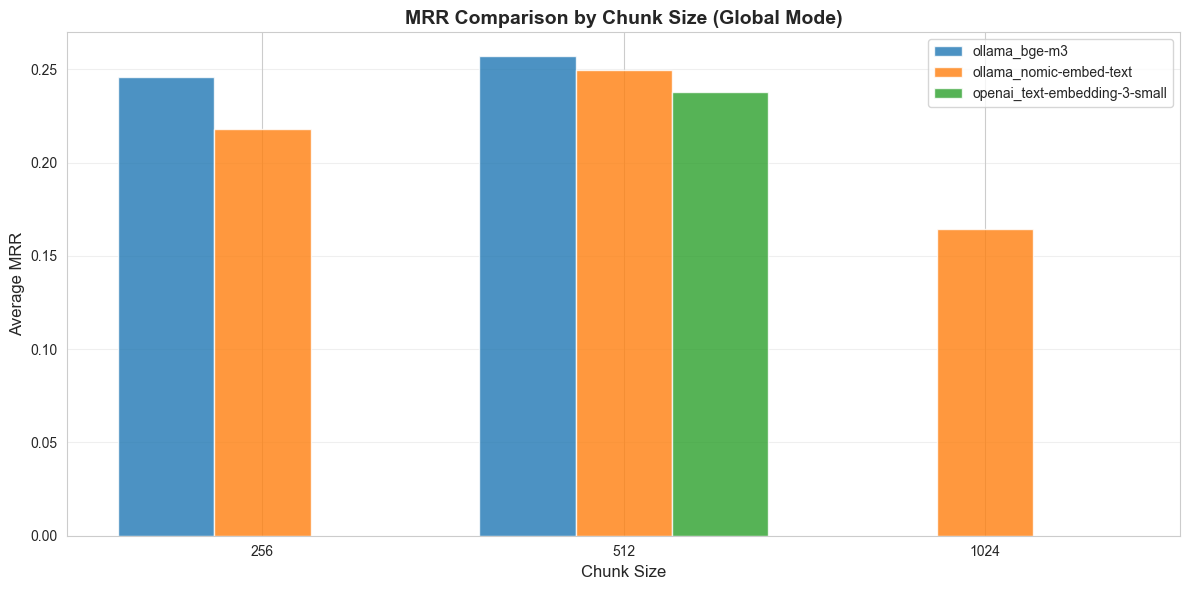

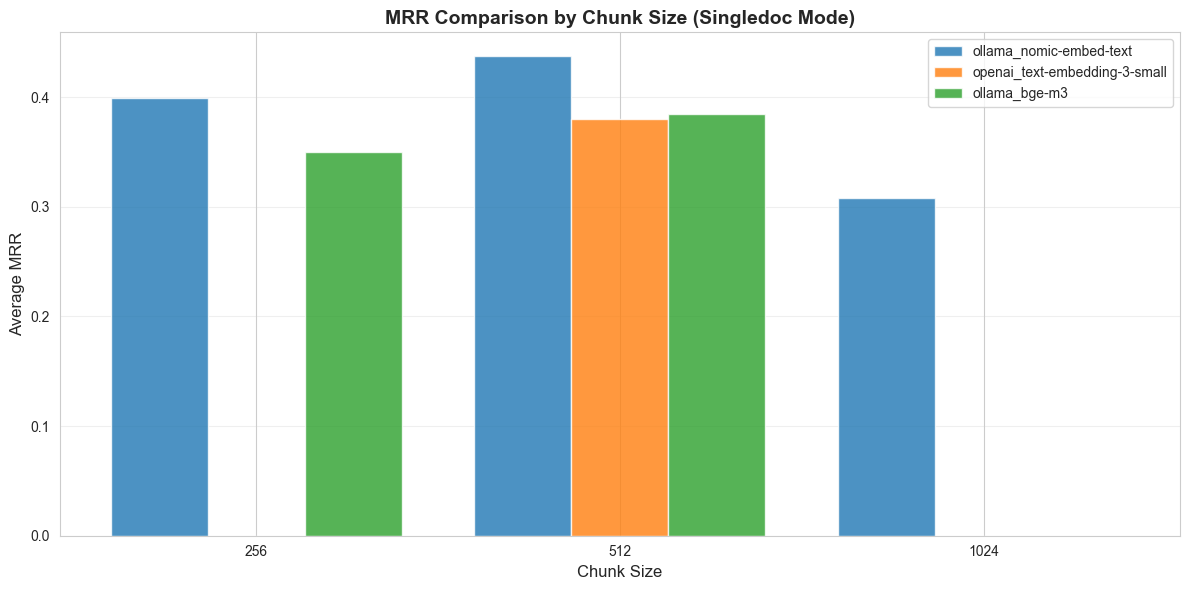

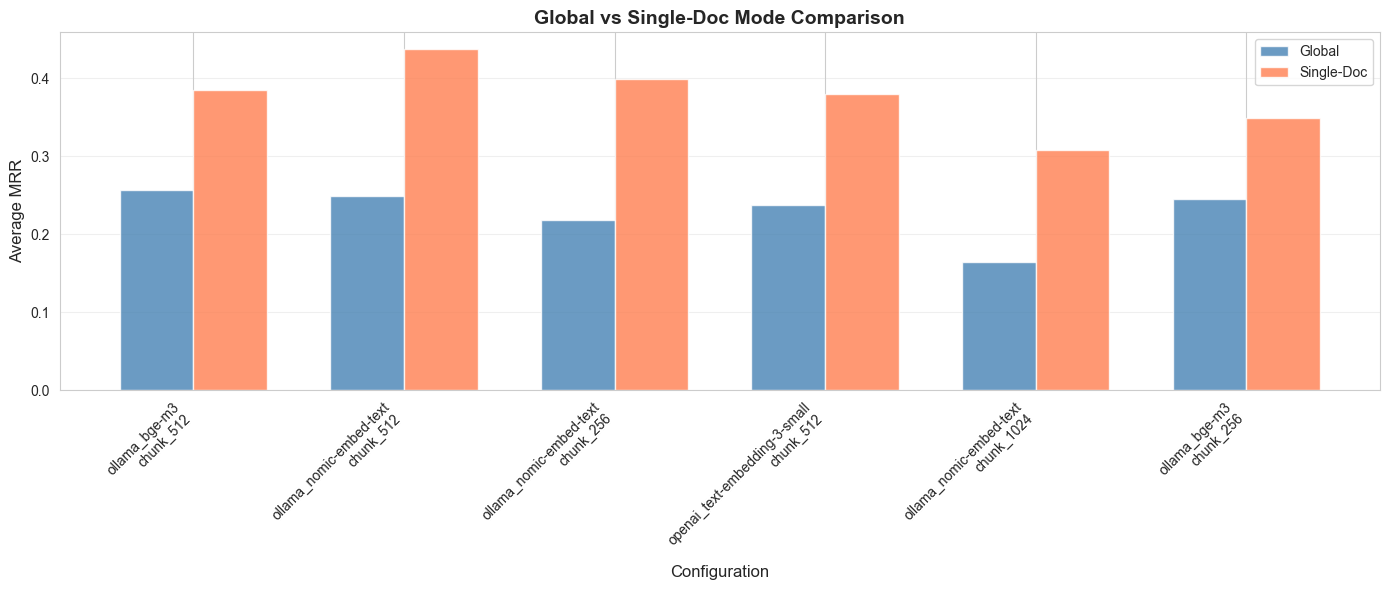

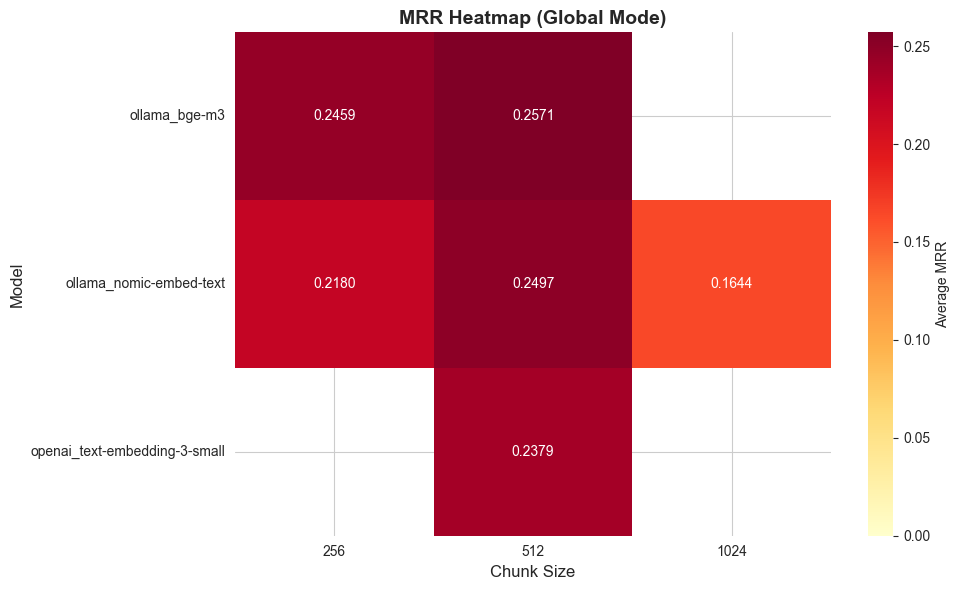

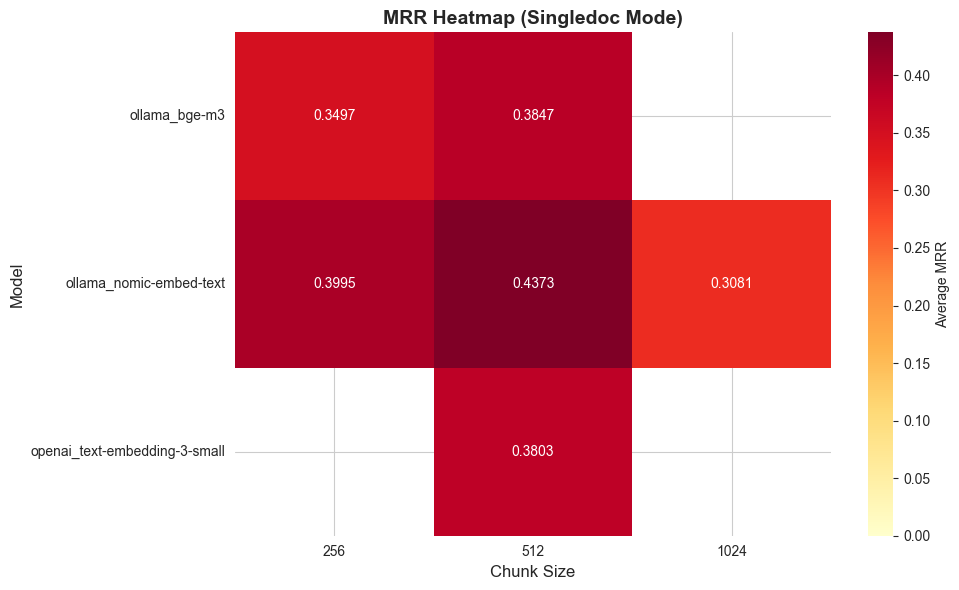


SUMMARY TABLE (Sorted by MRR)
provider                  model  chunk_size  k      mode average_mrr  total_queries
  ollama       nomic-embed-text         512 40 singledoc      0.4373            150
  ollama       nomic-embed-text         256 40 singledoc      0.3995            150
  ollama                 bge-m3         512 40 singledoc      0.3847            150
  openai text-embedding-3-small         512 40 singledoc      0.3803            150
  ollama                 bge-m3         256 40 singledoc      0.3497            150
  ollama       nomic-embed-text        1024 40 singledoc      0.3081            150
  ollama                 bge-m3         512 40    global      0.2571            150
  ollama       nomic-embed-text         512 40    global      0.2497            150
  ollama                 bge-m3         256 40    global      0.2459            150
  openai text-embedding-3-small         512 40    global      0.2379            150
  ollama       nomic-embed-text         256 4

In [21]:
# ============================================================================
# Step 5: Plotting Results
# ============================================================================

# %%
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# %% [markdown]
# ## 5.1 Load Results from JSON Files

# %%
def load_all_results(output_dir: str = OUTPUT_DIR) -> pd.DataFrame:
    """
    Load all JSON results into a DataFrame.
    
    Returns:
        DataFrame with columns: provider, model, chunk_size, k, mode, average_mrr
    """
    results = []
    
    output_path = Path(output_dir)
    json_files = list(output_path.glob("*.json"))
    
    print(f"Loading {len(json_files)} result files...")
    
    for filepath in json_files:
        try:
            with open(filepath, 'r') as f:
                data = json.load(f)
            
            # Get summary (last item in array)
            summary = data[-1].get('summary', {})
            
            if summary:
                results.append({
                    'provider': summary['provider'],
                    'model': summary['model'],
                    'chunk_size': summary['chunk_size'],
                    'k': summary['k'],
                    'mode': summary['mode'],
                    'average_mrr': summary['average_mrr'],
                    'total_queries': summary['total_queries']
                })
        except Exception as e:
            print(f"Error loading {filepath.name}: {e}")
    
    df = pd.DataFrame(results)
    print(f"✓ Loaded {len(df)} results")
    
    return df

# %%
# Load results
results_df = load_all_results()
print("\nResults summary:")
print(results_df)

# %% [markdown]
# ## 5.2 Plot: MRR by Chunk Size

# %%
def plot_mrr_by_chunk_size(df: pd.DataFrame, mode: str = "global"):
    """Plot MRR comparison across chunk sizes for a specific mode."""
    
    # Filter by mode
    df_filtered = df[df['mode'] == mode].copy()
    
    if df_filtered.empty:
        print(f"No data for mode: {mode}")
        return
    
    # Create model labels
    df_filtered['model_label'] = df_filtered['provider'] + '_' + df_filtered['model']
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Plot bars
    models = df_filtered['model_label'].unique()
    chunk_sizes = sorted(df_filtered['chunk_size'].unique())
    
    # Adjust width based on number of models
    if len(models) == 1:
        width = 0.5  # Wider bars for single model
    else:
        width = 0.8 / len(models)
    
    # Use categorical x positions
    x_positions = range(len(chunk_sizes))
    
    for i, model in enumerate(models):
        model_data = df_filtered[df_filtered['model_label'] == model].sort_values('chunk_size')
        
        if len(models) == 1:
            # Center single model bars
            positions = x_positions
        else:
            # Offset for multiple models
            offset = (i - len(models)/2 + 0.5) * width
            positions = [x + offset for x in x_positions]
        
        # Get MRR values for each chunk size
        mrr_values = []
        for cs in chunk_sizes:
            matching = model_data[model_data['chunk_size'] == cs]['average_mrr'].values
            mrr_values.append(matching[0] if len(matching) > 0 else 0)
        
        ax.bar(
            positions,
            mrr_values,
            width=width,
            label=model,
            alpha=0.8
        )
    
    ax.set_xlabel('Chunk Size', fontsize=12)
    ax.set_ylabel('Average MRR', fontsize=12)
    ax.set_title(f'MRR Comparison by Chunk Size ({mode.capitalize()} Mode)', fontsize=14, fontweight='bold')
    ax.set_xticks(x_positions)
    ax.set_xticklabels([str(cs) for cs in chunk_sizes])  # Convert to string labels
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    # Set y-axis to start at 0
    ax.set_ylim(bottom=0)
    
    plt.tight_layout()
    plt.show()

# %%
# Plot global mode
plot_mrr_by_chunk_size(results_df, mode="global")

# %%
# Plot single-doc mode
plot_mrr_by_chunk_size(results_df, mode="singledoc")

# %% [markdown]
# ## 5.3 Plot: Global vs Single-Doc Comparison

# %%
def plot_global_vs_singledoc(df: pd.DataFrame):
    """Compare global and single-doc modes."""
    
    # Pivot data
    pivot_data = []
    
    for _, row in df.iterrows():
        model_label = f"{row['provider']}_{row['model']}"
        chunk_label = f"chunk_{row['chunk_size']}"
        
        pivot_data.append({
            'model': model_label,
            'chunk_size': row['chunk_size'],
            'config': f"{model_label}\n{chunk_label}",
            'mode': row['mode'],
            'mrr': row['average_mrr']
        })
    
    pivot_df = pd.DataFrame(pivot_data)
    
    # Create grouped bar chart
    fig, ax = plt.subplots(figsize=(14, 6))
    
    configs = pivot_df['config'].unique()
    x = range(len(configs))
    width = 0.35
    
    global_data = []
    singledoc_data = []
    
    for config in configs:
        config_data = pivot_df[pivot_df['config'] == config]
        global_mrr = config_data[config_data['mode'] == 'global']['mrr'].values
        singledoc_mrr = config_data[config_data['mode'] == 'singledoc']['mrr'].values
        
        global_data.append(global_mrr[0] if len(global_mrr) > 0 else 0)
        singledoc_data.append(singledoc_mrr[0] if len(singledoc_mrr) > 0 else 0)
    
    ax.bar([i - width/2 for i in x], global_data, width, label='Global', alpha=0.8, color='steelblue')
    ax.bar([i + width/2 for i in x], singledoc_data, width, label='Single-Doc', alpha=0.8, color='coral')
    
    ax.set_xlabel('Configuration', fontsize=12)
    ax.set_ylabel('Average MRR', fontsize=12)
    ax.set_title('Global vs Single-Doc Mode Comparison', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(configs, rotation=45, ha='right')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# %%
plot_global_vs_singledoc(results_df)

# %% [markdown]
# ## 5.4 Plot: Heatmap of MRR Scores

# %%
def plot_mrr_heatmap(df: pd.DataFrame, mode: str = "global"):
    """Create heatmap of MRR scores."""
    
    df_filtered = df[df['mode'] == mode].copy()
    
    if df_filtered.empty:
        print(f"No data for mode: {mode}")
        return
    
    # Create pivot table
    df_filtered['model_label'] = df_filtered['provider'] + '_' + df_filtered['model']
    pivot = df_filtered.pivot(index='model_label', columns='chunk_size', values='average_mrr')
    
    # Create heatmap
    fig, ax = plt.subplots(figsize=(10, 6))
    
    sns.heatmap(
        pivot,
        annot=True,
        fmt='.4f',
        cmap='YlOrRd',
        cbar_kws={'label': 'Average MRR'},
        ax=ax,
        vmin=0,
        vmax=pivot.max().max()
    )
    
    ax.set_title(f'MRR Heatmap ({mode.capitalize()} Mode)', fontsize=14, fontweight='bold')
    ax.set_xlabel('Chunk Size', fontsize=12)
    ax.set_ylabel('Model', fontsize=12)
    
    plt.tight_layout()
    plt.show()

# %%
# Heatmap for global mode
plot_mrr_heatmap(results_df, mode="global")

# %%
# Heatmap for single-doc mode
plot_mrr_heatmap(results_df, mode="singledoc")

# %% [markdown]
# ## 5.5 Summary Table

# %%
def display_summary_table(df: pd.DataFrame):
    """Display formatted summary table."""
    
    # Sort by MRR
    df_sorted = df.sort_values('average_mrr', ascending=False)
    
    # Format for display
    display_df = df_sorted.copy()
    display_df['average_mrr'] = display_df['average_mrr'].apply(lambda x: f"{x:.4f}")
    
    print("\n" + "="*80)
    print("SUMMARY TABLE (Sorted by MRR)")
    print("="*80)
    print(display_df.to_string(index=False))
    print("="*80)

# %%
display_summary_table(results_df)

# %% [markdown]
# ## 5.6 Save Plots

# %%
def save_all_plots(df: pd.DataFrame, output_dir: str = OUTPUT_DIR):
    """Save all plots to files."""
    
    plots_dir = Path(output_dir) / "plots"
    plots_dir.mkdir(exist_ok=True)
    
    print(f"Saving plots to {plots_dir}...")
    
    # Plot 1: Global mode by chunk size
    plt.figure(figsize=(12, 6))
    plot_mrr_by_chunk_size(df, mode="global")
    plt.savefig(plots_dir / "mrr_by_chunk_global.png", dpi=300, bbox_inches='tight')
    plt.close()
    
    # Plot 2: Single-doc mode by chunk size
    plt.figure(figsize=(12, 6))
    plot_mrr_by_chunk_size(df, mode="singledoc")
    plt.savefig(plots_dir / "mrr_by_chunk_singledoc.png", dpi=300, bbox_inches='tight')
    plt.close()
    
    # Plot 3: Global vs Single-doc
    plt.figure(figsize=(14, 6))
    plot_global_vs_singledoc(df)
    plt.savefig(plots_dir / "global_vs_singledoc.png", dpi=300, bbox_inches='tight')
    plt.close()
    
    # Plot 4: Heatmap global
    plt.figure(figsize=(10, 6))
    plot_mrr_heatmap(df, mode="global")
    plt.savefig(plots_dir / "heatmap_global.png", dpi=300, bbox_inches='tight')
    plt.close()
    
    # Plot 5: Heatmap single-doc
    plt.figure(figsize=(10, 6))
    plot_mrr_heatmap(df, mode="singledoc")
    plt.savefig(plots_dir / "heatmap_singledoc.png", dpi=300, bbox_inches='tight')
    plt.close()
    
    print(f"✓ Saved 5 plots to {plots_dir}")

# %%
# Uncomment to save plots
# save_all_plots(results_df)